In [1]:
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math
import pandas as pd
from PIL import Image, ImageDraw
rng = np.random.default_rng()


In [2]:
%%bash
slim -s 119 -d R0=10 -d 'OUTPUT="bearded_seal_parents.csv"' -d 'POPSIZE_FILE="bearded_seal_popsize.csv"' bearded_seals/bearded_seals.slim

// Initial random seed:
119

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeSex("A");
22026
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.56419, sexSegregation="FM");
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeMutationRate(0);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 



In [2]:
parents = pd.read_csv("bearded_seal_parents.csv")

### Define a sampling intensity grid and sample from dead animals for each year according to the grid

In [3]:
def sample_cell_year(sample_parents, year, xmin, xmax, ymin, ymax, nmax):
    # Sample from individuals within one grid cell
    in_x = np.logical_and(sample_parents.loc[:,'x'] <= xmax, sample_parents.loc[:,'x'] >= xmin)
    in_y = np.logical_and(sample_parents.loc[:,'y'] >= ymin, sample_parents.loc[:,'y'] <= ymax)
    in_cell = np.logical_and(in_x, in_y)
    in_year = sample_parents.loc[:,'sampling_time'] == year
    in_i = np.where(np.logical_and(in_cell, in_year))[0]
    # Sample size is nmax or the number of individuals in the area
    ss = min(len(in_i), nmax)
    sample_rows = rng.choice(in_i, ss, replace = False)
    return(ss, sample_rows)

In [9]:
def sample_grid(individuals, years, sampling_intensity, n, width = 10, height = 10):
    # Sample from each grid cell
    # Sample size 
    ss = np.array(np.floor(n*sampling_intensity/(np.sum(sampling_intensity)*len(years))), dtype = int)
    # Keep track of actual total sample size (since if there are fewer than ss individuals in a grid cell, all are sampled)
    realized_ss = 0
    
    # Width and height of grid cells
    x_cells = ss.shape[0]
    y_cells = ss.shape[1]
    dx = width/x_cells
    dy = height/y_cells
    
    # Keep track of sampled rows
    #sample_rows = np.empty(round(np.sum(ss)), dtype = int)
    sample_rows = np.empty(0, dtype = int)
    # Sample from each grid cell
    for ix, iy in np.ndindex(ss.shape):
        for year in years:
            xmin = dx*ix
            xmax = dx*ix + dx
            ymin = dy*iy
            ymax = dy*iy + dy
            nmax = ss[ix, iy]
            grid_year_ss, grid_rows = sample_cell_year(individuals, year, xmin, xmax, ymin, ymax, nmax)
            sample_rows = np.concatenate([sample_rows, grid_rows])
            realized_ss += grid_year_ss
    return(realized_ss, sample_rows)

### Make plots of sample

In [11]:
def make_spaghetti(sample_parents, image_w, image_h, max_width, max_height):
    # creating new Image object
    w, h = image_w, image_h
    spaghetti = Image.new("1", (w, h))
    img1 = ImageDraw.Draw(spaghetti)

    # Find individuals with a parent that is in the sample
    p_in_i = np.isin(sample_parents.loc[:,'parent1'], sample_parents.loc[:,'individual'])
    npairs = sum(p_in_i)

    # Get location of parent-offspring pairs and plot
    children = sample_parents.loc[p_in_i, :]
    for child_i, child_row in children.iterrows():
        parent_i = np.where(sample_parents.loc[:,'individual'] == child_row['parent1'])[0][0]
        parent_row = sample_parents.iloc[parent_i,:]
        # print(parent_row['individual'], child_row['individual'])
        x_child, y_child = child_row[['x','y']]
        x_parent, y_parent = parent_row[['x','y']]
        img1.line([(x_child*w/max_width, y_child*h/max_height), (x_parent*w/max_width, y_parent*h/max_height)], fill ="white", width = 0)

    return(spaghetti, npairs)

In [12]:
def plot_samples(sample_parents, image_w, image_h, max_width, max_height):
    # creating new Image object
    w, h = image_w, image_h
    sampling = Image.new("1", (w, h))
    img2 = ImageDraw.Draw(sampling)

    # Plot sampling
    for ind_i, ind_row in sample_parents.iterrows():
        x, y = ind_row[['x','y']]
        img2.point((x*w/max_width, y*h/max_height), fill = "white")
    return(sampling)

In [13]:
max_bias = 10
def plot_intensity(sampling_intensity, image_w, image_h, max_int = max_bias):
    w, h = image_w, image_h
    intensity = Image.new("L", (w, h))
    img3 = ImageDraw.Draw(intensity)

    # Width and height of grid cells
    x_cells = sampling_intensity.shape[0]
    y_cells = sampling_intensity.shape[1]
    dx = w/x_cells
    dy = h/y_cells
    # Maximum sampling intensity (will be 255 or all white)
    # Plot sampling intensity
    for ix, iy in np.ndindex(sampling_intensity.shape):
        xmin = dx*ix
        xmax = dx*ix + dx
        ymin = dy*iy
        ymax = dy*iy + dy
        # Sampling
        rel_intensity = round(255*sampling_intensity[ix, iy]/max_int)
        img3.rectangle([(xmin, ymin), (xmax, ymax)], fill = rel_intensity, outline=None, width=0)
    return(intensity)

In [6]:
# Divide into years and sample for each year
sample_years = np.unique(parents.loc[:,'sampling_time'])
print(sample_years) 

[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [12]:
max_bias = 15
sampling_intensity =  np.repeat([np.linspace(1, max_bias, 10)], 10, axis = 0)
ss, sample_rows = sample_grid(parents,sample_years, sampling_intensity, 2000, 10, 10)
print(ss)
print(sample_rows)
sample = parents.iloc[sample_rows]
print(sample)

1050
[ 2438  3644  6849 ... 54514 57584 61590]
       individual  parent1  parent2  age  sampling_time         x        y
2438       130490   101842   127844    5             40  0.027382  5.60339
3644       127590   110977   116200    7             41  0.812199  5.00293
6849       134419   109831   100592    6             42  0.331097  5.54305
12095      148340   126656   135380    2             43  0.428211  5.07956
12886      137772   125934   135658    6             44  0.671096  5.61508
...           ...      ...      ...  ...            ...       ...      ...
50248      165335   149651   159727    9             56  9.888330  9.77322
52132      178843   148141   172006    6             57  9.234440  9.27236
54514      152559   134544   131771   16             58  9.092830  9.51872
57584      168085   157944   144569   11             59  9.915880  9.38360
61590      198589   170060   195037    2             60  9.602630  9.01061

[1050 rows x 7 columns]


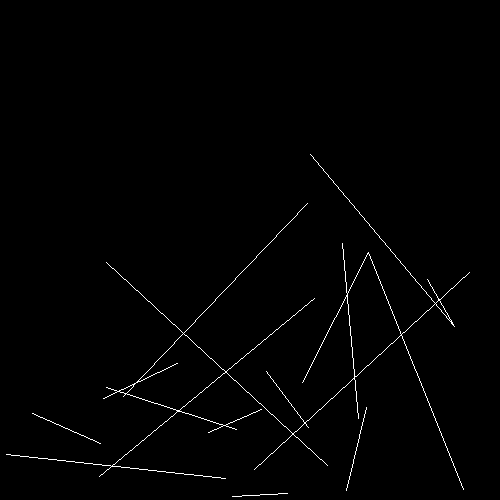

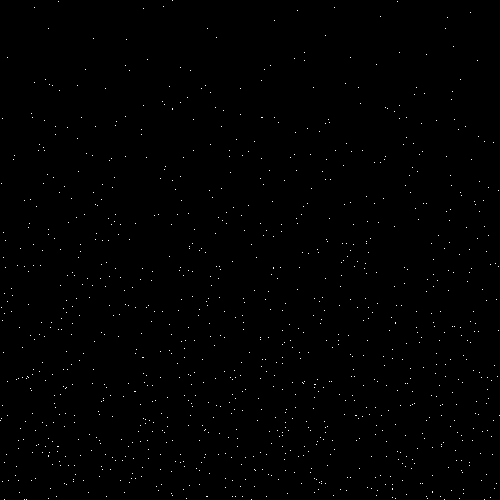

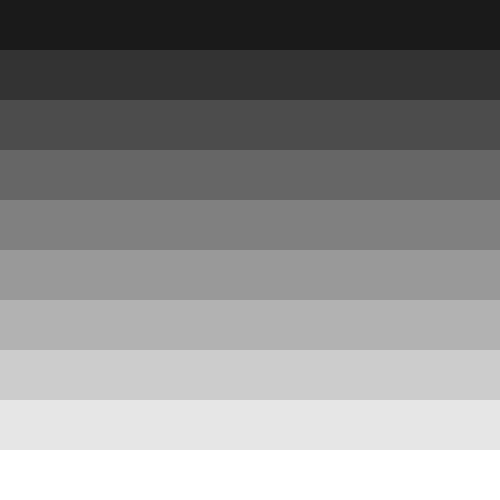

In [17]:
display(make_spaghetti(sample, 500, 500, 10, 10)[0])
display(plot_samples(sample, 500, 500, 10, 10))
display(plot_intensity(sampling_intensity, 500, 500))

In [13]:
popsize = pd.read_csv("bearded_seal_popsize.csv")

In [14]:
print(popsize)
print(popsize.columns)
np.mean(popsize.loc[:,'N'])

    sampling_time      N
0              40  18013
1              41  17995
2              42  17997
3              43  17923
4              44  17772
5              45  17693
6              46  17630
7              47  17459
8              48  17398
9              49  17354
10             50  17397
11             51  17438
12             52  17391
13             53  17305
14             54  17267
15             55  17206
16             56  17111
17             57  17026
18             58  16936
19             59  16951
20             60  16873
Index(['sampling_time', 'N'], dtype='object')


17435.0

In [16]:
np.sum(ss)

1050